In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 4.47 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.89 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 759 µs


### Database ERD

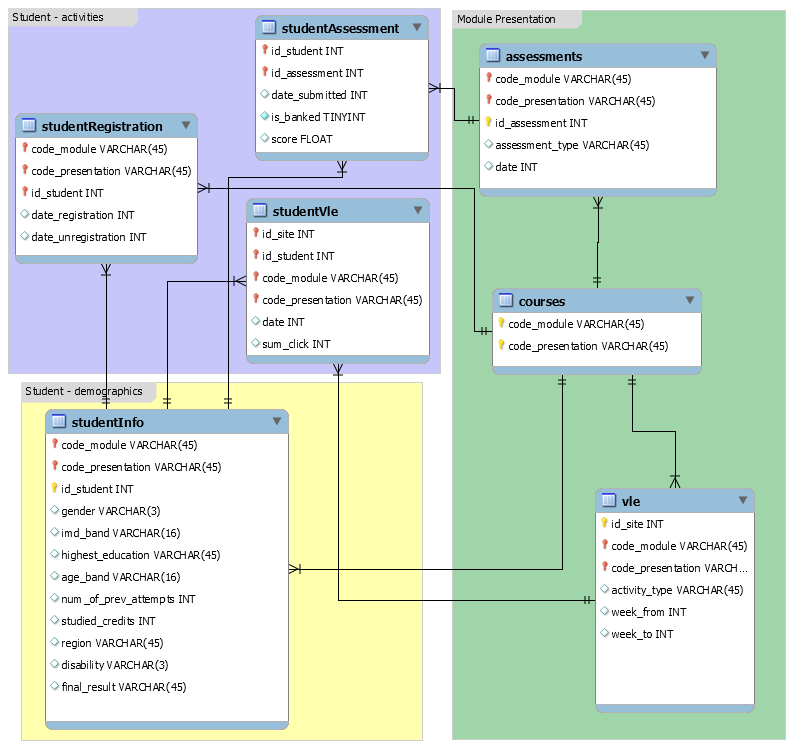

time: 3.47 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.54 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.57 ms


## Half Term Data

In [8]:
path = os.path.join(gparent, 'data/processed/test.csv')
df = pd.read_csv(path)

time: 64.8 ms


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24770 entries, 0 to 24769
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   score                 22202 non-null  float64
 1   gender                22219 non-null  object 
 2   region                22219 non-null  object 
 3   highest_education     22219 non-null  object 
 4   imd_band              21332 non-null  object 
 5   age_band              22219 non-null  object 
 6   num_of_prev_attempts  22219 non-null  float64
 7   studied_credits       22219 non-null  float64
 8   disability            22219 non-null  object 
 9   final_result          22219 non-null  object 
 10  date_sub              22219 non-null  float64
 11  course_length         22219 non-null  float64
 12  row_id                24770 non-null  object 
 13  target                22219 non-null  float64
 14  weighted_ave          22217 non-null  float64
 15  mean_score         

In [10]:
df.describe()

,score,num_of_prev_attempts,studied_credits,date_sub,course_length,target,weighted_ave,mean_score,median_score,id_site,date,sum_click,sum_activity,date_registration,date_unregistration
count,22202.000000,22219.000000,22219.000000,22219.000000,22219.000000,22219.000000,22217.000000,22217.000000,22217.000000,22219.000000,22219.000000,22219.000000,22219.000000,24770.000000,2255.000000
mean,73.492523,0.146496,75.465142,25.178541,239.721995,0.327918,113.110186,75.296531,75.653936,744075.783024,-4.346325,2.747918,313.787119,-65.488736,170.795565
std,20.958447,0.453636,37.220055,14.311197,5.701796,0.469465,65.361515,14.850148,14.772224,125709.321062,27.225546,5.802341,369.247540,47.117116,33.475645
min,0.000000,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,0.000000,526721.000000,-25.000000,1.000000,2.000000,-311.000000,121.000000
25%,65.000000,0.000000,60.000000,18.000000,240.000000,0.000000,68.800000,67.666667,68.000000,673519.000000,-17.000000,1.000000,80.000000,-94.000000,144.000000
50%,78.000000,0.000000,60.000000,21.000000,240.000000,0.000000,120.560000,78.333333,78.000000,768351.000000,-10.000000,1.000000,192.000000,-52.000000,165.000000
75%,88.000000,0.000000,90.000000,31.000000,241.000000,1.000000,159.000000,86.000000,86.000000,832780.000000,-5.000000,3.000000,408.000000,-29.000000,198.000000
max,100.000000,6.000000,630.000000,119.000000,268.000000,1.000000,303.840000,100.000000,100.000000,947016.000000,119.000000,511.000000,5806.000000,167.000000,444.000000


time: 58.7 ms


In [11]:
f.col_pop(df, 'target')
f.col_pop(df, 'row_id', 1)
conversions = ['target', 'studied_credits']
df[conversions] = df[conversions].apply(pd.to_numeric)
# adding course_load column
df['course_load'] = pd.qcut(df.studied_credits, q=4,\
                                labels=['Light', 'Medium', 'Heavy'],\
                                duplicates='drop')

time: 20.3 ms


In [12]:
df.shape

(24770, 24)

time: 1.86 ms


In [13]:
df['imd_band'] = df['imd_band'].replace(['10-20'], '10-20%')
# renaming values
df['disability'] = df['disability'].replace(['Y', 'N'], ['Yes', 'No'])
df['gender'] = df['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 10.3 ms


In [14]:
df.shape

(24770, 24)

time: 2.4 ms


In [15]:
Q1 = df.studied_credits.quantile(0.25)
Q3 = df.studied_credits.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.studied_credits < (Q1 - 1.5 * IQR))\
                        |(df.studied_credits > (Q3 + 1.5 * IQR)))].copy()
           
Q1 = df.weighted_ave.quantile(0.25)
Q3 = df.weighted_ave.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.weighted_ave < (Q1 - 1.5 * IQR))\
                        |(df.weighted_ave > (Q3 + 1.5 * IQR)))].copy()

time: 15.4 ms


In [16]:
df.shape

(23584, 24)

time: 1.99 ms


In [17]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration']

time: 720 µs


In [18]:
df = df.drop(drops, axis=1)

time: 2.56 ms


In [19]:
df.shape

(23584, 13)

time: 2.37 ms


In [20]:
df = df.dropna()

time: 8.59 ms


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20196 entries, 1 to 24769
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20196 non-null  float64 
 1   gender                20196 non-null  object  
 2   region                20196 non-null  object  
 3   highest_education     20196 non-null  object  
 4   imd_band              20196 non-null  object  
 5   age_band              20196 non-null  object  
 6   num_of_prev_attempts  20196 non-null  float64 
 7   disability            20196 non-null  object  
 8   weighted_ave          20196 non-null  float64 
 9   mean_score            20196 non-null  float64 
 10  median_score          20196 non-null  float64 
 11  sum_activity          20196 non-null  float64 
 12  course_load           20196 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 2.0+ MB
time: 13.4 ms


In [22]:
df.target.value_counts(normalize=True)

0.0    0.671024
1.0    0.328976
Name: target, dtype: float64

time: 3.68 ms


## Creating Holdout Data

In [23]:
# splitting data & target
X, y = f.X_y(df)

time: 2.27 ms


In [24]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 10.9 ms


## Creating Training Data

In [25]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 7.99 ms


## Baseline Model: Dummy Classifier

In [26]:
dummy = DummyClassifier(strategy='most_frequent')

time: 700 µs


In [27]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 810 µs


### Fitting Model

In [28]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 30.2 ms


### Saving Model

In [29]:
# f.pickle_model(baseline, 'baseline')

time: 575 µs


### Cross Val Scores

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6710387323943662
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 146 ms


### Test Data Confusion Matrix

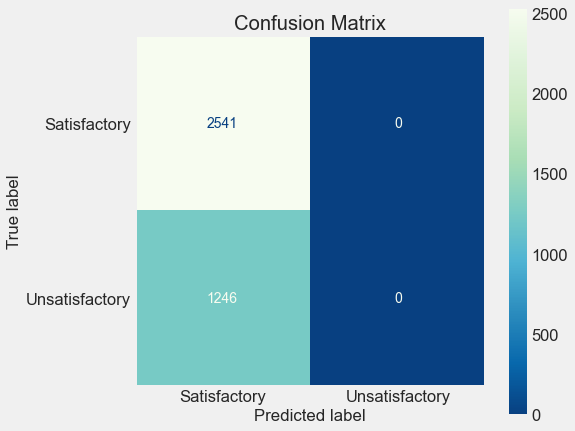

,Accuracy,F1,Recall,Precision
0,0.67098,0.0,0.0,0.0


time: 326 ms


In [31]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [32]:
mnb = MultinomialNB()

time: 730 µs


In [33]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 862 µs


### Fitting Model

In [34]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>)])),
                ('multinomialnb', MultinomialNB())])

time: 26.5 ms


### Saving Model

In [35]:
# f.pickle_model(fsm, 'fsm')

time: 566 µs


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6700704225352113
 fsm has an average F1 of 0.19225373579849833
 fsm has an average Recall of 0.11934690634194534
 fsm has an average Precision of 0.49532255749938037
time: 167 ms


### Test Data Confusion Matrix

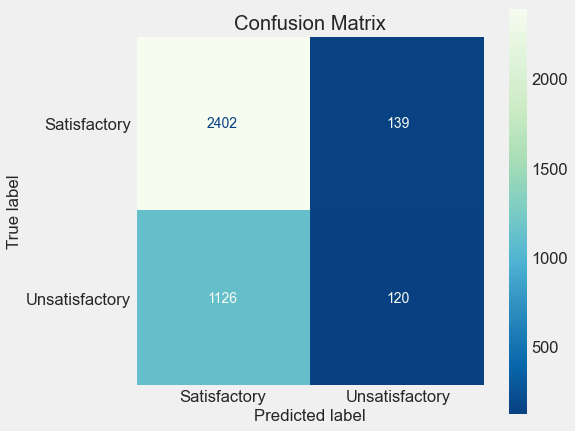

,Accuracy,F1,Recall,Precision
0,0.665963,0.159468,0.096308,0.46332


time: 330 ms


In [37]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# SS Test

## KNeighborsClassifier

In [38]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 867 µs


In [39]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.18 ms


### Fitting Model

In [40]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 39.3 ms


In [41]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 586 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7264084507042254
knn_ss has an average F1 of 0.5372597570935733
knn_ss has an average Recall of 0.483003314505795
knn_ss has an average Precision of 0.6055295055042498
time: 4.29 s


### Test Data Confusion Matrix

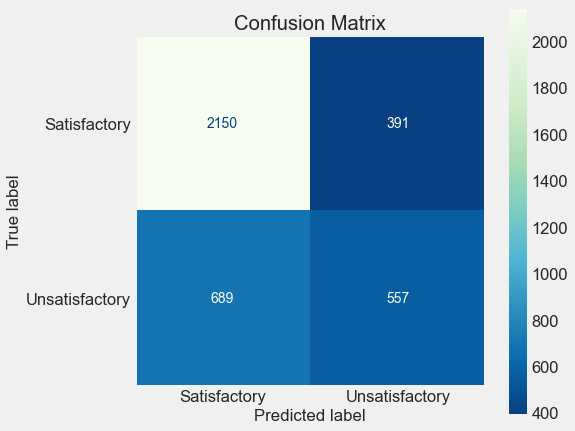

,Accuracy,F1,Recall,Precision
0,0.714814,0.507748,0.44703,0.587553


time: 8.39 s


In [43]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [44]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 793 µs


In [45]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 893 µs


### Fitting Model

In [46]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.19 s


In [47]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 609 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7450704225352112
logreg_ss has an average F1 of 0.5356590987105171
logreg_ss has an average Recall of 0.4471536770969797
logreg_ss has an average Precision of 0.6681616736992132
time: 7.15 s


### Test Data Confusion Matrix

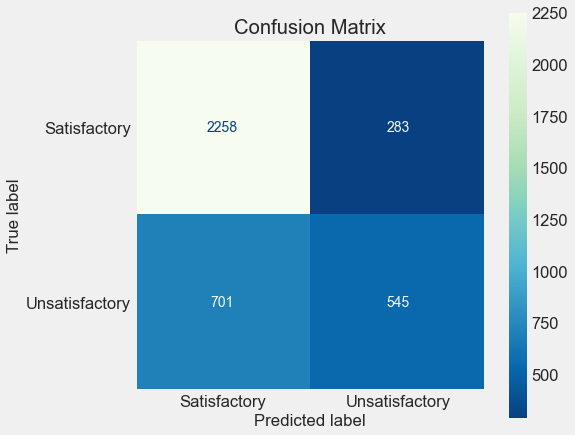

,Accuracy,F1,Recall,Precision
0,0.740164,0.525554,0.4374,0.658213


time: 191 ms


In [49]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [50]:
SVC = SVC()

time: 772 µs


In [51]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 817 µs


### Fitting Model

In [52]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('svc', SVC())])

time: 5.01 s


In [53]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 631 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7536091549295775
svc_ss has an average F1 of 0.5437072626822588
svc_ss has an average Recall of 0.4463511801215557
svc_ss has an average Precision of 0.6955706490394541
time: 19.2 s


### Test Data Confusion Matrix

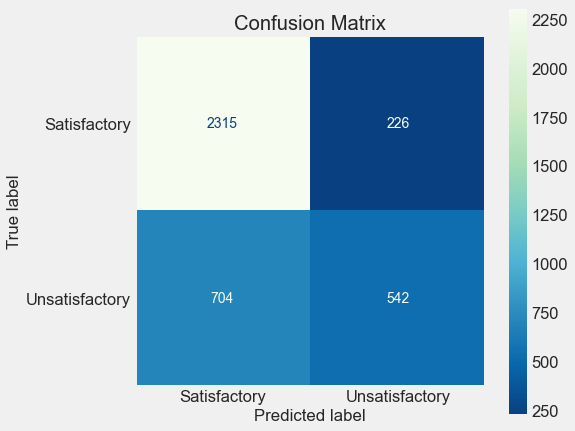

,Accuracy,F1,Recall,Precision
0,0.754423,0.538232,0.434992,0.705729


time: 5.62 s


In [55]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [56]:
LSVC = LinearSVC(random_state=2021)

time: 756 µs


In [57]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 814 µs


### Fitting Model

In [58]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 653 ms


In [59]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 599 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7431338028169014
lsvc_ss has an average F1 of 0.5241941420204969
lsvc_ss has an average Recall of 0.43029622948120466
lsvc_ss has an average Precision of 0.6707870182988867
time: 2.41 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

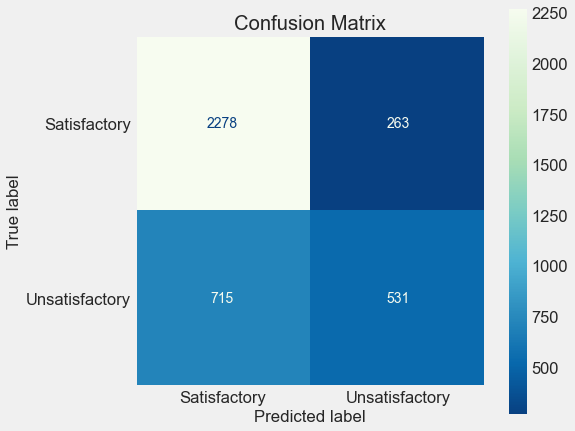

,Accuracy,F1,Recall,Precision
0,0.741748,0.520588,0.426164,0.668766


time: 200 ms


In [61]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [62]:
DT = DecisionTreeClassifier(random_state=2021)

time: 923 µs


In [63]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 828 µs


### Fitting Model

In [64]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 435 ms


In [65]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 888 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6897887323943662
dt_ss has an average F1 of 0.5313389518665691
dt_ss has an average Recall of 0.5346573459613857
dt_ss has an average Precision of 0.5283598939106459
time: 1.65 s


### Test Data Confusion Matrix

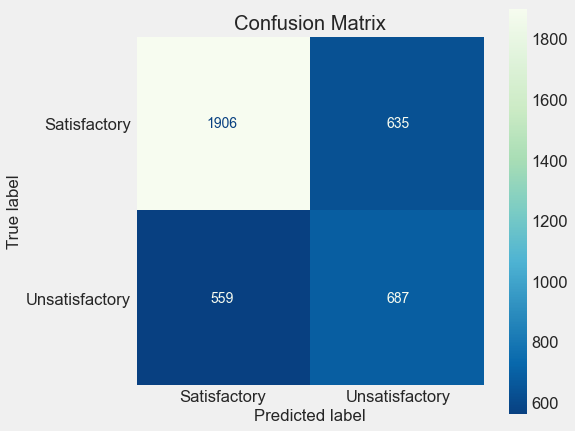

,Accuracy,F1,Recall,Precision
0,0.684711,0.535047,0.551364,0.519667


time: 199 ms


In [67]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [68]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 779 µs


In [69]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 944 µs


### Fitting Model

In [70]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.85 s


In [71]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 642 µs


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7527288732394366
bclf_ss has an average F1 of 0.5650483058051383
bclf_ss has an average Recall of 0.4883648676703247
bclf_ss has an average Precision of 0.6709605838140001
time: 10.2 s


### Test Data Confusion Matrix

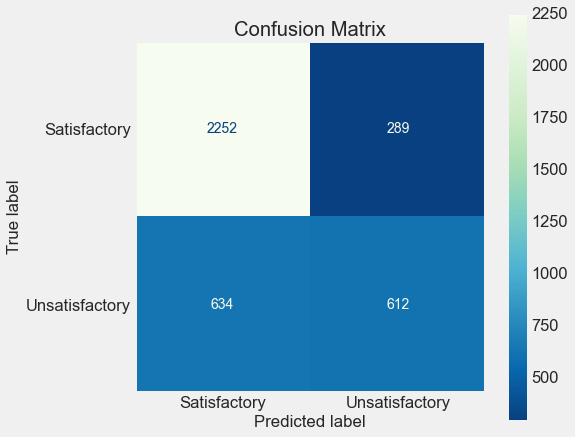

,Accuracy,F1,Recall,Precision
0,0.756271,0.570098,0.491172,0.679245


time: 266 ms


In [73]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [74]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 813 µs


In [75]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 868 µs


### Fitting Model

In [76]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.9 s


In [77]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 708 µs


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7662852112676057
rf_ss has an average F1 of 0.5889414845097307
rf_ss has an average Recall of 0.5092390954191096
rf_ss has an average Precision of 0.6986585208003516
time: 9.56 s


### Test Data Confusion Matrix

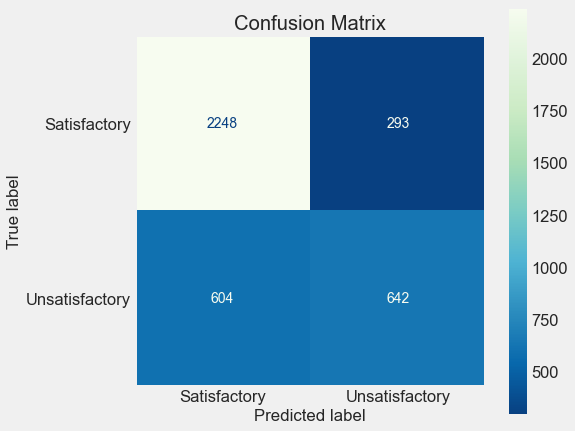

,Accuracy,F1,Recall,Precision
0,0.763137,0.588721,0.515249,0.686631


time: 429 ms


In [79]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [80]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 773 µs


In [81]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.06 ms


### Fitting Model

In [82]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 452 ms


In [83]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 650 µs


### Cross Val Scores

In [84]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6922535211267606
ada_ss has an average F1 of 0.5361659903895346
ada_ss has an average Recall of 0.5408131635275504
ada_ss has an average Precision of 0.5319772971422234
time: 1.69 s


### Test Data Confusion Matrix

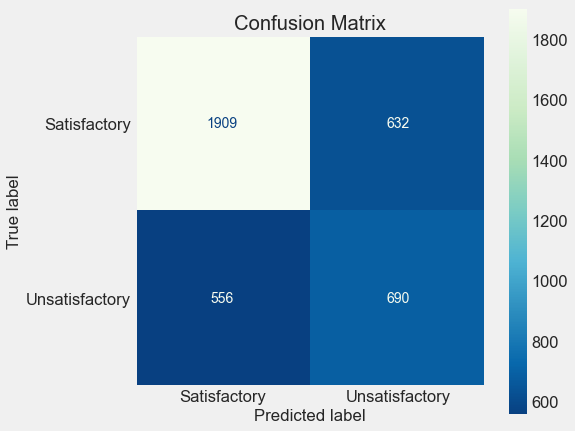

,Accuracy,F1,Recall,Precision
0,0.686295,0.537383,0.553772,0.521936


time: 205 ms


In [85]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [86]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 898 µs


In [87]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 958 µs


### Fitting Model

In [88]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 678 ms


In [89]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 814 µs


### Cross Val Scores

In [90]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 3.28 s


### Test Data Confusion Matrix

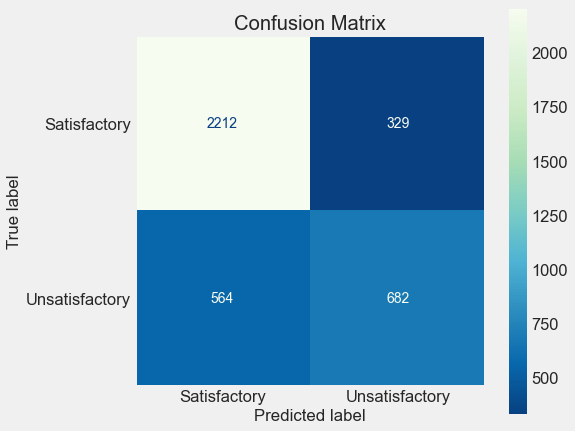

,Accuracy,F1,Recall,Precision
0,0.764193,0.604342,0.547352,0.67458


time: 330 ms


In [91]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [92]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
8,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()
9,ada_ss,0.692254,0.536166,0.540813,0.531977,1.688419,AdaBoost SS()


time: 8.82 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [93]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.39 ms


In [94]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.07 ms


### Fitting Model

In [95]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.03 s


In [96]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 624 µs


### Cross Val Scores

In [97]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

time: 23.4 s


### Test Data Confusion Matrix

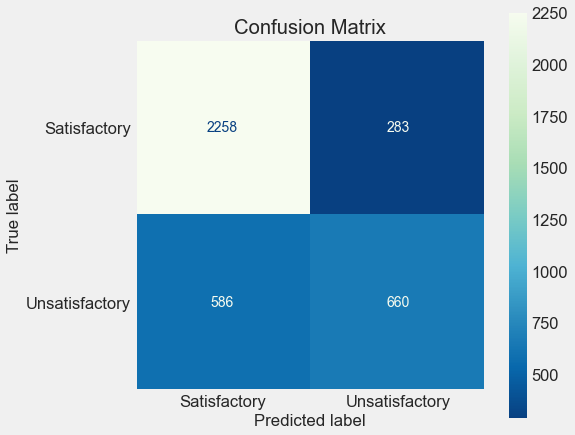

,Accuracy,F1,Recall,Precision
0,0.770531,0.603015,0.529695,0.699894


time: 823 ms


In [98]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [99]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
11,vc_ss,0.770246,0.597971,0.519675,0.704580,23.368059,Voting CLF SS()
8,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()


time: 10.8 ms


## Neural Network

### Create Model

In [100]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=40, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.54 ms


In [101]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.28 ms


### Pipeline

In [102]:
nn_ss = make_pipeline(preprocessing_ss, NN)

time: 1.17 ms


### Fitting Models

In [103]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1880fa880>)])

time: 5.34 s


In [104]:
# saving model
# path = os.path.join(gparent,'models/nn_ss.h5')
# nn_ss[2].model.save(path)

time: 750 µs


### Cross Val Scores

In [105]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

time: 23.5 s


### Test Data Confusion Matrix

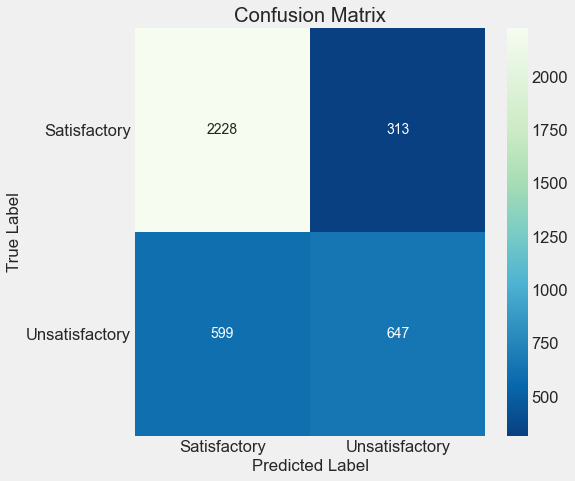

,Accuracy,F1,Recall,Precision
0,0.759176,0.586582,0.519262,0.673958


time: 763 ms


In [106]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary

In [107]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
8,vc_ss,0.770246,0.597971,0.519675,0.704580,23.368059,Voting CLF SS()
9,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()


time: 11.1 ms


## Voting CLF SMOTE

In [108]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.24 ms


In [109]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.42 ms


### Fitting Model

In [110]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 9.15 s


In [111]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 593 µs


### Cross Val Scores

In [112]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

time: 32 s


### Test Data Confusion Matrix

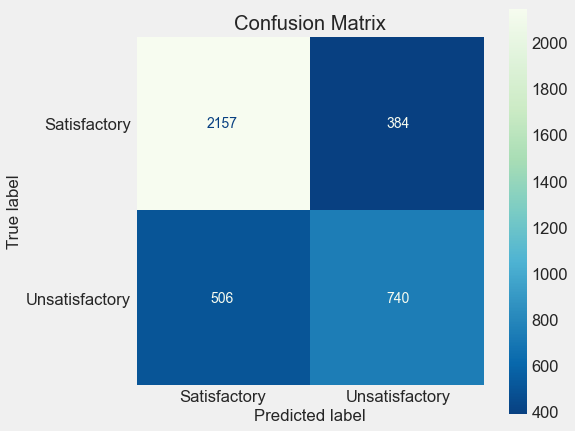

,Accuracy,F1,Recall,Precision
0,0.764985,0.624473,0.5939,0.658363


time: 827 ms


In [113]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [114]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
8,vc_ss,0.770246,0.597971,0.519675,0.704580,23.368059,Voting CLF SS()
9,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()


time: 13.9 ms


vc_ss smote acc=0.773504 f1=0.639068 recall=0.609586 precision=0.671745 click_sum, num_activities

vc_ss smote acc=0.771 f1=0.635 recall=0.604 precision=0.669 click_sum+num_activities

## Neural Network SMOTE

### Pipeline

In [115]:
# nn_sm = make_sm_pipeline(preprocessing_ss, sm, NN)

time: 684 µs


### Fitting Models

In [116]:
# %%capture --no-display
# nn_sm.fit(X_train, y_train)

time: 806 µs


### Cross Val Scores

In [117]:
# %%capture --no-display
# modeling.report(nn_sm, X_train, y_train, 'nn_sm',\
#                 'Neural Net SS()/SMOTE')

time: 913 µs


### Test Data Confusion Matrix

In [118]:
# %%capture --no-display
# f.confusion_report_nn(nn_sm, X_test, y_test)

time: 848 µs


In [119]:
# saving model
# path = os.path.join(gparent,'models/nn_sm.h5')
# nn_sm[2].model.save(path)

time: 769 µs


## Model Summary

In [120]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
8,vc_ss,0.770246,0.597971,0.519675,0.704580,23.368059,Voting CLF SS()
9,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()


time: 17.1 ms


## XGBoost SMOTE

In [121]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.16 ms


### Fitting Model

In [122]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8ce9a0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f8cedf0>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.02 s


In [123]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 814 µs


### Cross Val Scores

In [124]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

time: 8.89 s


### Test Data Confusion Matrix

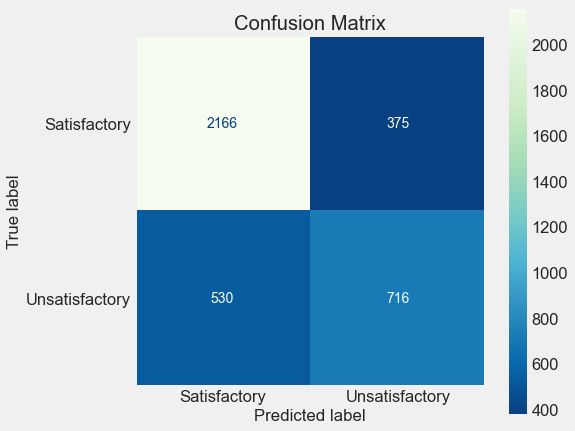

,Accuracy,F1,Recall,Precision
0,0.761025,0.612751,0.574639,0.656279


time: 469 ms


In [125]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Model Summary

In [126]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671039,0.000000,0.000000,0.000000,0.143426,Baseline DummyCFL
1,fsm,0.670070,0.192254,0.119347,0.495323,0.163545,FSM Naive Bayes
2,lsvc_ss,0.743134,0.524194,0.430296,0.670787,2.411057,Linear SVC SS()
3,svc_ss,0.753609,0.543707,0.446351,0.695571,19.190919,Support Vector CLF SS()
4,logreg_ss,0.745070,0.535659,0.447154,0.668162,7.142002,LogReg SS()
5,knn_ss,0.726408,0.537260,0.483003,0.605530,4.279260,KNN SS()
6,bclf_ss,0.752729,0.565048,0.488365,0.670961,10.183872,Bagging CLF SS()
7,rf_ss,0.766285,0.588941,0.509239,0.698659,9.552234,Random Forest SS()
8,vc_ss,0.770246,0.597971,0.519675,0.704580,23.368059,Voting CLF SS()
9,dt_ss,0.689789,0.531339,0.534657,0.528360,1.643068,Decision Tree CLF SS()


time: 14.8 ms


In [127]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 26.1 ms
